# Time series: ARIMA example

* Ref: [https://www.kaggle.com/kashnitsky/topic-9-time-series-arima-example](https://www.kaggle.com/kashnitsky/topic-9-time-series-arima-example)
* Data: on kaggle

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display
import statsmodels.api as sm

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/accidental-deaths-in-usa-monthly.csv',
                 index_col=['Month'], parse_dates=['Month'])
df.head()

,Accidental deaths in USA: monthly,1973 ? 1978
Month,,
1973-01-01,9007,NaN
1973-02-01,8106,NaN
1973-03-01,8928,NaN
1973-04-01,9137,NaN
1973-05-01,10017,NaN


In [ ]:
df.columns

Index([' Accidental deaths in USA: monthly', ' 1973 ? 1978'], dtype='object')

In [ ]:
df.rename(columns={' Accidental deaths in USA: monthly': 'num'}, inplace=True)
df.drop(columns=[' 1973 ? 1978'], inplace=True)
df.head()

,num
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017


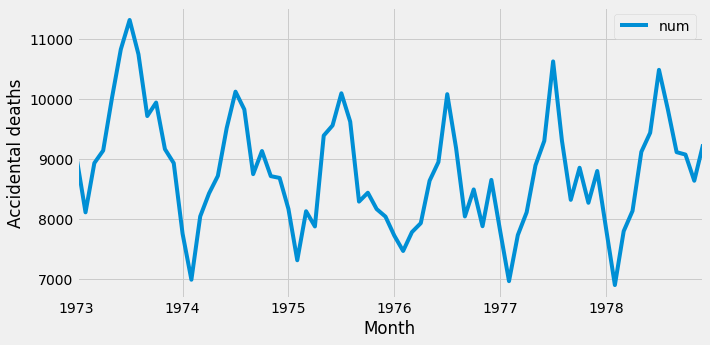

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
ax.set_ylabel('Accidental deaths')
plt.show()

看起來有 seasonality 但是有沒有 trend 還看不出來

## 2. Analysis
* 檢查 stationality
* 檢查 correlation

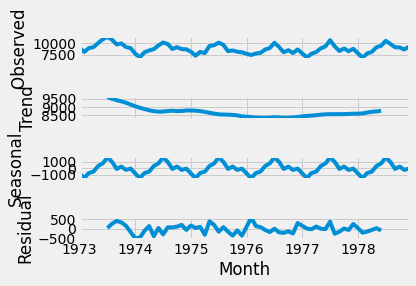

In [ ]:
# Decompose to trend, seasonality, residual
decomposition = sm.tsa.seasonal_decompose(df['num'])
fig = decomposition.plot() # 圖太小，而且沒辦法直接改尺寸，除非分開畫四張圖
plt.show()

所以有很明顯的 seasonality 也有 trend，但是圖太小了，所以單獨畫每張圖來放大

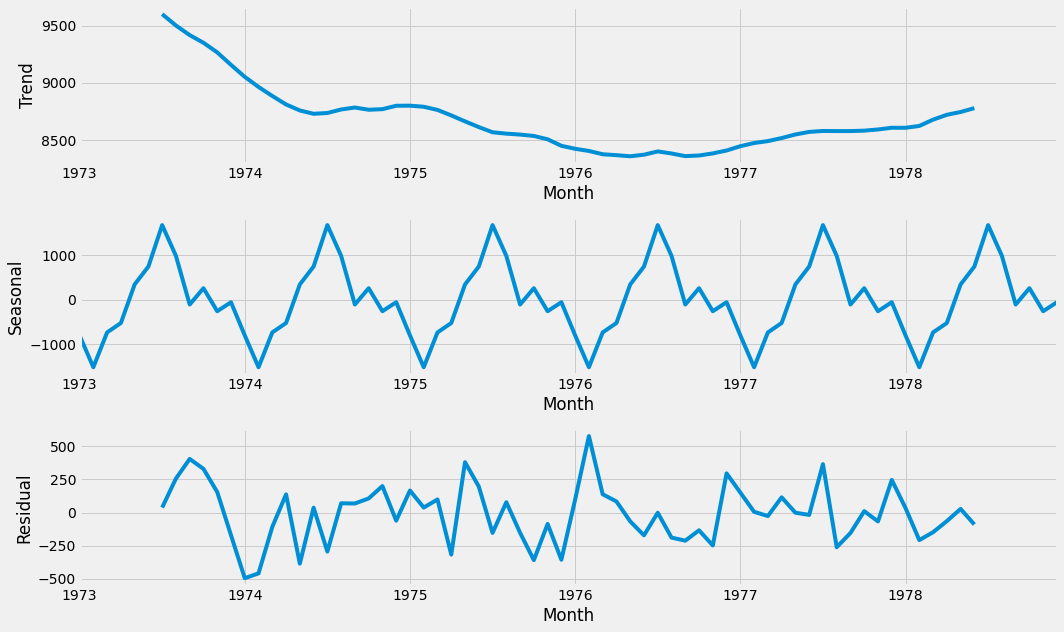

In [ ]:
# 改成單獨畫每張圖
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(3, 1, figsize=(15, 9))
trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')

seasonal.plot(ax=ax[1])
ax[1].set_ylabel('Seasonal')

residual.plot(ax=ax[2])
ax[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# Use augmented dickey-fuller test to check stationality
from statsmodels.tsa.stattools import adfuller
adf_test = sm.tsa.stattools.adfuller(df['num'])
print(adf_test)
print(f'Dickey-Fuller test: ADF={adf_test[0]}, p-value={adf_test[1]}')

(-2.5557984096356785, 0.10248122056865122, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 870.8496020346796)
Dickey-Fuller test: ADF=-2.5557984096356785, p-value=0.10248122056865122


* Dickey-Fuller 的 null hypothesis 是假設 time series 是 non-stationary 的，這邊求出的 $p$ 值也比 0.05 還要大，所以不能 reject null hypothesis，表示這個 time series 是 non-stationary 的
* 用 seasonal differentiation 來移除 trend 使得 time series 是 stationary

,num,num_diff1
Month,,
1973-01-01,9007,NaN
1973-02-01,8106,NaN
1973-03-01,8928,NaN
1973-04-01,9137,NaN
1973-05-01,10017,NaN


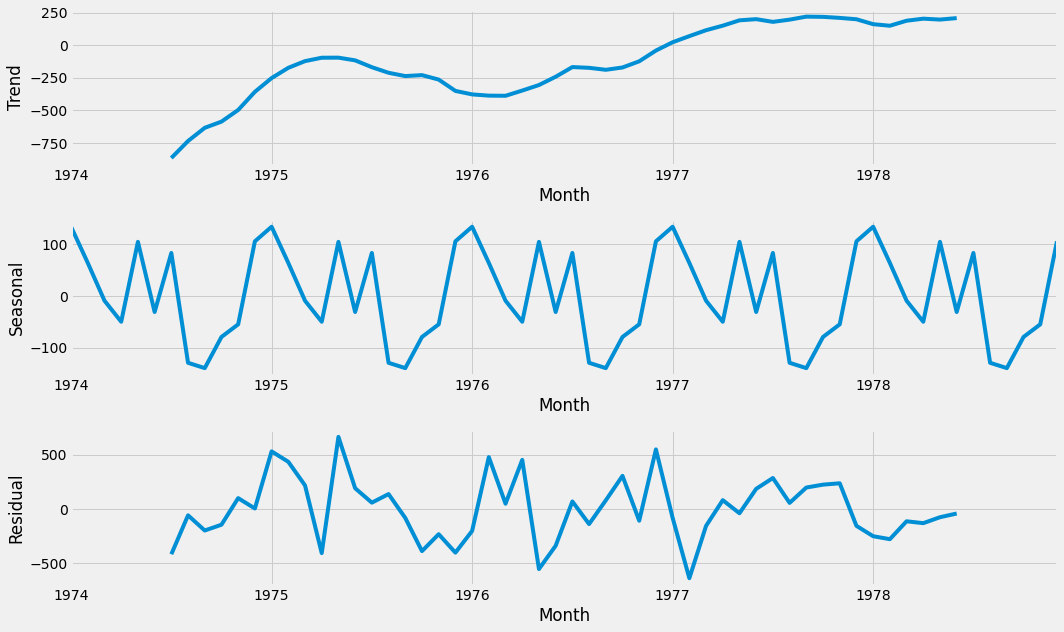

(-3.305137924614224, 0.01465036542343818, 0, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 702.6765809003224)
Dickey-Fuller test: ADF=-3.305137924614224, p-value=0.01465036542343818


In [ ]:
df['num_diff1'] = df['num'] - df['num'].shift(12)
display(df.head())

decomposition = sm.tsa.seasonal_decompose(df['num_diff1'][12:]) # df['num_diff'] 前 12 個是空的，所以不能用
# fig = decomposition.plot()
# plt.show()

# 改成單獨畫每張圖
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(3, 1, figsize=(15, 9))
trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')

seasonal.plot(ax=ax[1])
ax[1].set_ylabel('Seasonal')

residual.plot(ax=ax[2])
ax[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Use augmented dickey-fuller test to check stationality
from statsmodels.tsa.stattools import adfuller
adf_test = sm.tsa.stattools.adfuller(df['num_diff1'][12:])
print(adf_test)
print(f'Dickey-Fuller test: ADF={adf_test[0]}, p-value={adf_test[1]}')

$p$-value $< 0.05$ 可以 reject null hypothesis 了，但是仍然看得出來有 trend，所以在做一次 differentiation

,num,num_diff1,num_diff2
Month,,,
1973-01-01,9007,NaN,NaN
1973-02-01,8106,NaN,NaN
1973-03-01,8928,NaN,NaN
1973-04-01,9137,NaN,NaN
1973-05-01,10017,NaN,NaN


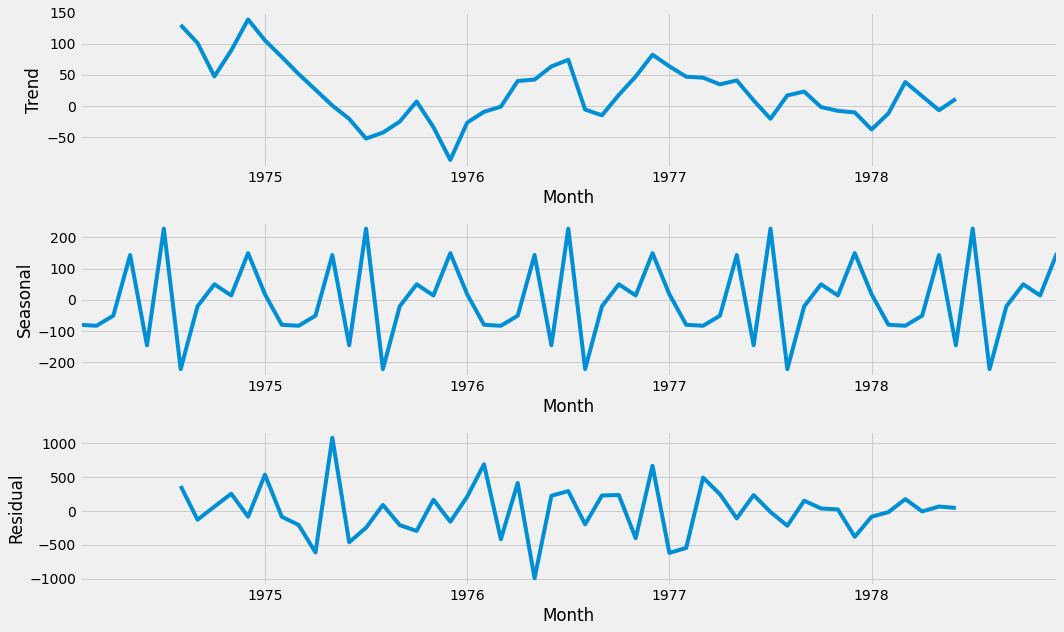

(-7.937464007784133, 3.383322341102076e-12, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, 689.7303910939829)
Dickey-Fuller test: ADF=-7.937464007784133, p-value=3.383322341102076e-12


In [ ]:
df['num_diff2'] = df['num_diff1'] - df['num_diff1'].shift(1)
display(df.head())

decomposition = sm.tsa.seasonal_decompose(df['num_diff2'][13:]) # df['num_diff2'] 前 13 個是空的，所以不能用
# fig = decomposition.plot()
# plt.show()

# 改成單獨畫每張圖
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(3, 1, figsize=(15, 9))
trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')

seasonal.plot(ax=ax[1])
ax[1].set_ylabel('Seasonal')

residual.plot(ax=ax[2])
ax[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Use augmented dickey-fuller test to check stationality
from statsmodels.tsa.stattools import adfuller
adf_test = sm.tsa.stattools.adfuller(df['num_diff2'][13:])
print(adf_test)
print(f'Dickey-Fuller test: ADF={adf_test[0]}, p-value={adf_test[1]}')

現在 trend 和 $p$-value 都顯示 time series 是 stationary 了，這樣才可以套用 ARIMA

* 畫圖看 correlation
    * `lag_plot()`, `autocorrelation_plot()`
    * `plot_acf()`, `plot_pacf()`

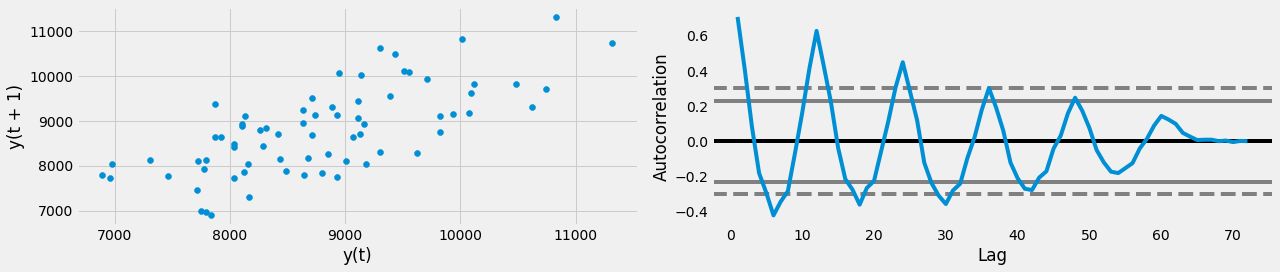

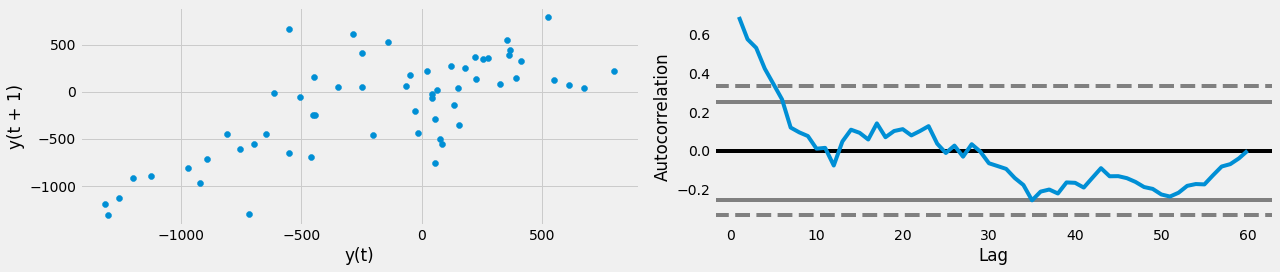

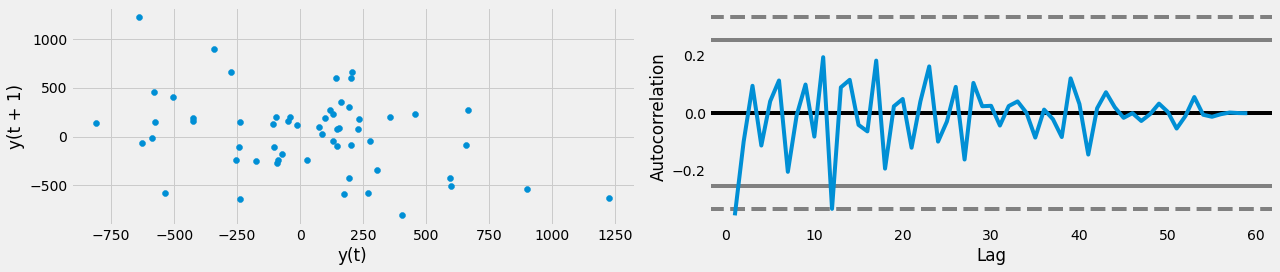

In [ ]:
# Use num
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
pd.plotting.lag_plot(df['num'], ax=ax[0])
pd.plotting.autocorrelation_plot(df['num'], ax=ax[1])
plt.tight_layout()
plt.show()

# Use num_diff1
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
pd.plotting.lag_plot(df['num_diff1'], ax=ax[0])
pd.plotting.autocorrelation_plot(df['num_diff1'][12:], ax=ax[1])
plt.tight_layout()
plt.show()

# Use num_diff2
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
pd.plotting.lag_plot(df['num_diff2'], ax=ax[0])
pd.plotting.autocorrelation_plot(df['num_diff2'][13:], ax=ax[1])
plt.tight_layout()
plt.show()

沒有用 differentiate 時，還有用 d=1 時，都看得出來有 correlation，但是用了 d=2 之後反而看起來就沒有 correlation 了

用 ACF 和 PACF 可以來看要使用的  Q 和 P 的初始值是多少
* ACF 看 Q 值，PACF 看 P 值
* 看的是和 95% CI (灰色實線) 的交叉

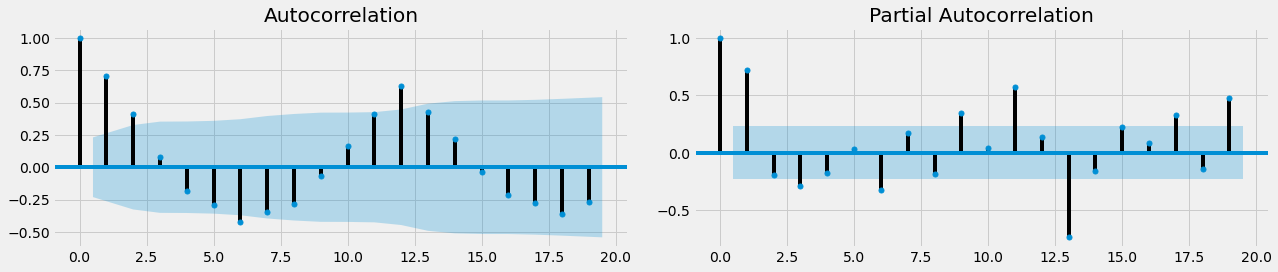

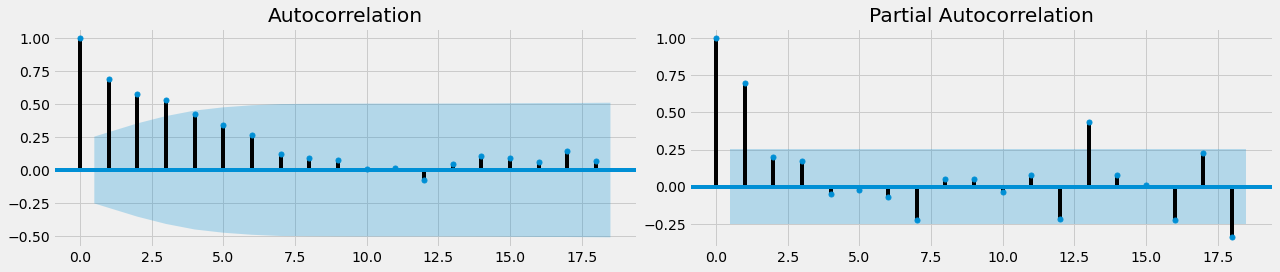

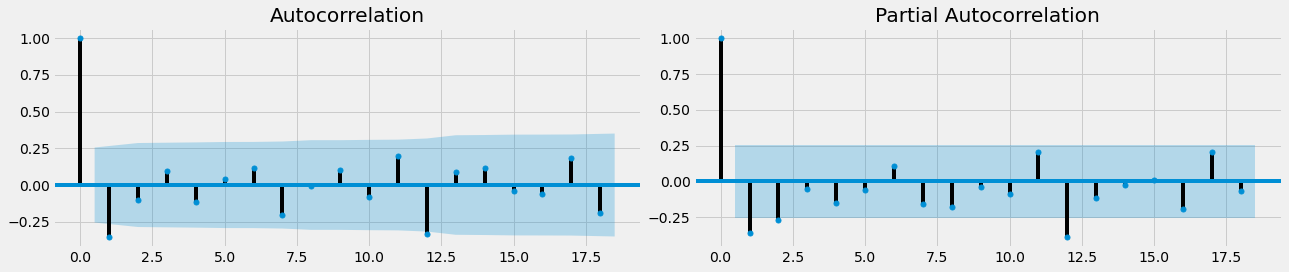

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Use num
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(df['num'], ax=ax[0])
plot_pacf(df['num'], ax=ax[1])
plt.tight_layout()
plt.show()

# Use num_diff1
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(df['num_diff1'][12:], ax=ax[0])
plot_pacf(df['num_diff1'][12:], ax=ax[1])
plt.tight_layout()
plt.show()

# Use num_diff2
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(df['num_diff2'][13:], ax=ax[0])
plot_pacf(df['num_diff2'][13:], ax=ax[1])
plt.tight_layout()
plt.show()

從 PACF 中看到 P 大概是 2，從 ACF 看 Q 大概是 1，所以可以用來建立所有可能的 (p, d, q) 組合

## 3. Forecast

In [ ]:
# 原始的 ARIMA 用的 p, d, q
ps = range(0, 3)
d = 1
qs = range(0, 1)

# seasonal 用的 p, d, q
Ps = range(0, 3)
D = 1
Qs = range(0, 3)

from itertools import product
params = product(ps, qs, Ps,Qs)
list_of_params = list(params)
print(len(list_of_params), list_of_params)

27 [(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1, 0, 2, 0), (1, 0, 2, 1), (1, 0, 2, 2), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 0, 2), (2, 0, 1, 0), (2, 0, 1, 1), (2, 0, 1, 2), (2, 0, 2, 0), (2, 0, 2, 1), (2, 0, 2, 2)]


接下來就用全部的 (p, q, P, Q) 來找出最好的組合
* AIC 越小表示 model 越好，所以用使 AIC 最小的那一組 (p, q, P, Q)

In [ ]:
%%time
results = []
best_aic = float('inf')
best_model = None
best_params = None

import warnings
warnings.filterwarnings('ignore') # 把 warning 濾掉

for params in list_of_params:
  # 會有一些 params 的組合不好，不能跑模型，所以要做例外處理
  try:
    model = sm.tsa.statespace.SARIMAX(df['num'], # 這邊是用原始數據，不是用 differentiate 後的
                                      order = (params[0], d, params[1]),
                                      seasonal_order = (params[2], D, params[3], 12))
    model_fit = model.fit(disp=-1) # disp < 0 就是表示不要印出 convergence information
  except ValueError:
    print(f'wrong parameters: {params}')
    continue

  aic = model_fit.aic

  # save best model, it's AIC and params
  if aic < best_aic:
    best_model = model_fit
    best_aic = aic
    best_params = params

  results.append([params, aic]) # 只存好的參數組合和其 AIC

warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (1, 0, 0, 2)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 2)
wrong parameters: (2, 0, 0, 2)
wrong parameters: (2, 0, 1, 2)
wrong parameters: (2, 0, 2, 2)
CPU times: user 11.1 s, sys: 7.72 s, total: 18.8 s
Wall time: 9.62 s


In [ ]:
df_results = pd.DataFrame(results, columns=['params', 'aic'])
df_results.sort_values(by='aic', ascending=True, inplace=True)
df_results.head()

,params,aic
13,"(2, 0, 0, 1)",854.647098
7,"(1, 0, 0, 1)",855.458079
16,"(2, 0, 2, 0)",856.494101
15,"(2, 0, 1, 1)",856.614483
10,"(1, 0, 2, 0)",856.648917


In [ ]:
# Best model
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                num   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -423.324
Date:                            Tue, 09 Jun 2020   AIC                            854.647
Time:                                    01:44:34   BIC                            862.957
Sample:                                01-01-1973   HQIC                           857.891
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.1960      0.170   

最好的一組 (p, d, q)x(P, D, Q, seasonal)=(2, 1, 0)x(0, 1, 1, 12)，AIC 值是 854.647

In [ ]:
print(best_aic)
print(best_params)

854.6470984894999
(2, 0, 0, 1)


檢查一下 residual 
* 是不是 biased? $\rightarrow$ 用 1 sample student test 檢查
* 是不是 stationary? $\rightarrow$ 用 Dickey-Fuller test 檢查
* 有沒有 autocorrelation? $\rightarrow$ 畫圖看，或是用 Ljung-Box test 檢查

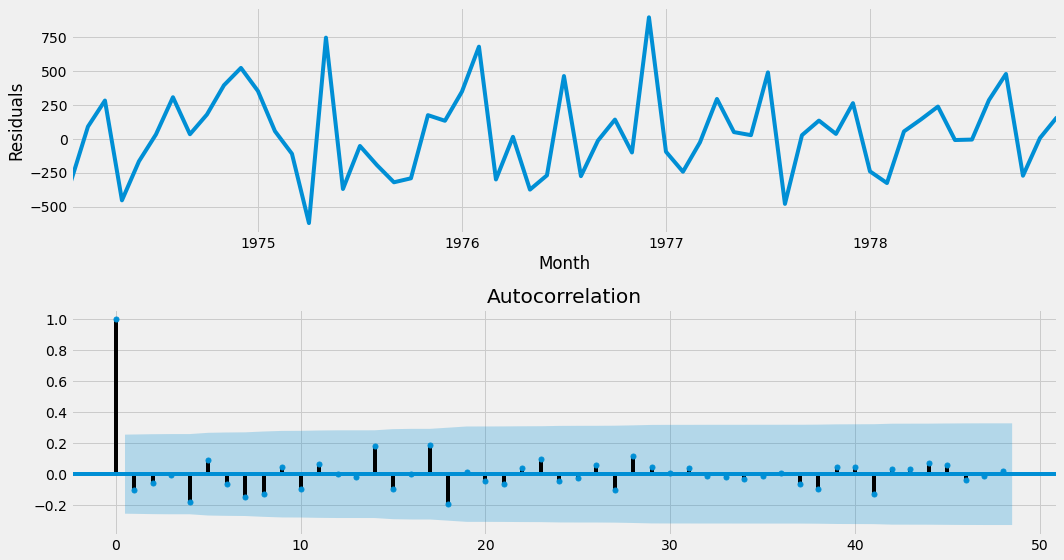

Students' criterion: p=0.27437293257635925
Dickey-Fuller criterion: p=2.1612031248536273e-13


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
best_model.resid[13:].plot(ax=ax[0])
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values, lags=48, ax=ax[1]) # 畫 48 個 lags 來看
plt.tight_layout()
plt.show()

from scipy import stats
student_test = stats.ttest_1samp(best_model.resid[13:], 0)[1]
adf_test = adfuller(best_model.resid[13:])[1]

print(f"Students' criterion: p={student_test}")
print(f'Dickey-Fuller criterion: p={adf_test}')
# print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
# print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

所以由圖和 $p$-value 知道 residual 沒有 bias, 是 stationary, 沒有 autocorrelation

然後把 model fit 到的結果和原始的疊圖比較，來驗證 model fitting 的好壞

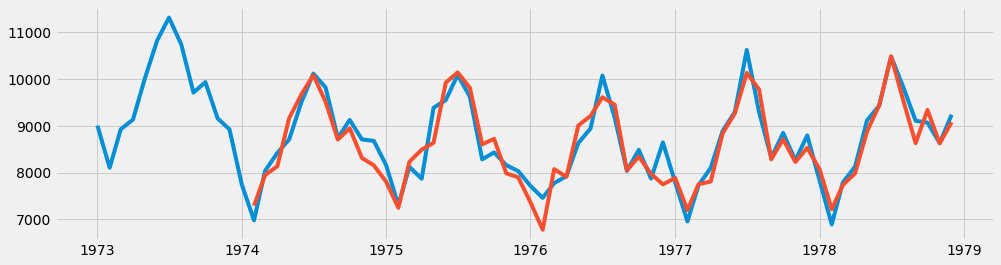

In [ ]:
df['model'] =best_model.fittedvalues

fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(df['num'], label='actual')
plt.plot(df['model'][13:], label='predicted')
plt.show()

這個 model 看起來很不錯，所以可以拿來預測未來的事件

In [ ]:
display(df.head())
display(df.tail())
print(len(df))

,num,num_diff1,num_diff2,model
Month,,,,
1973-01-01,9007,NaN,NaN,0.000000
1973-02-01,8106,NaN,NaN,8823.426830
1973-03-01,8928,NaN,NaN,8086.458805
1973-04-01,9137,NaN,NaN,8955.774411
1973-05-01,10017,NaN,NaN,9103.728507


,num,num_diff1,num_diff2,model
Month,,,,
1978-08-01,9827,525.0,666.0,9540.021613
1978-09-01,9110,796.0,271.0,8630.213165
1978-10-01,9070,220.0,-576.0,9341.519804
1978-11-01,8633,368.0,148.0,8626.373412
1978-12-01,9240,444.0,76.0,9079.122879


72


產生一個新的 dataframe 有從 1973 到 1980 的資料，其中 1973 到 1978 就是用原始資料，然後用 model 來預測 1979 和 1980 的資料

In [ ]:
date = pd.date_range(start='1973-01-01', periods=8*12, freq='MS') # 產生 8 年份的時間區間，彼此間隔一個月，用月初當區間開始日期
date

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01', '1973-11-01', '1973-12-01',
               '1974-01-01', '1974-02-01', '1974-03-01', '1974-04-01',
               '1974-05-01', '1974-06-01', '1974-07-01', '1974-08-01',
               '1974-09-01', '1974-10-01', '1974-11-01', '1974-12-01',
               '1975-01-01', '1975-02-01', '1975-03-01', '1975-04-01',
               '1975-05-01', '1975-06-01', '1975-07-01', '1975-08-01',
               '1975-09-01', '1975-10-01', '1975-11-01', '1975-12-01',
               '1976-01-01', '1976-02-01', '1976-03-01', '1976-04-01',
               '1976-05-01', '1976-06-01', '1976-07-01', '1976-08-01',
               '1976-09-01', '1976-10-01', '1976-11-01', '1976-12-01',
               '1977-01-01', '1977-02-01', '1977-03-01', '1977-04-01',
               '1977-05-01', '1977-06-01', '1977-07-01', '1977-08-01',
      

In [ ]:
df_future = pd.DataFrame(date, columns=['Month'])
df_future = df_future.merge(df[['num']].reset_index(), on='Month', how='left')

predictions = best_model.predict(start=len(df), end=len(df_future))
df_predictions = predictions.to_frame().rename(columns={0: 'predicted'})
display(df_predictions.head())

df_future = df_future.merge(df_predictions.reset_index().rename(columns={'index':'Month'}), 
                            on='Month', how='left')
df_future.set_index('Month', inplace=True)
display(df_future)

,predicted
1979-01-01,8351.669794
1979-02-01,7542.299348
1979-03-01,8347.092420
1979-04-01,8615.726179
1979-05-01,9516.636648


,num,predicted
Month,,
1973-01-01,9007.0,NaN
1973-02-01,8106.0,NaN
1973-03-01,8928.0,NaN
1973-04-01,9137.0,NaN
1973-05-01,10017.0,NaN
...,...,...
1980-08-01,NaN,10330.485799
1980-09-01,NaN,9415.124002
1980-10-01,NaN,9628.331692


In [ ]:
display(df_future.iloc[70:75])

,num,predicted
Month,,
1978-11-01,8633.0,NaN
1978-12-01,9240.0,NaN
1979-01-01,NaN,8351.669794
1979-02-01,NaN,7542.299348
1979-03-01,NaN,8347.092420


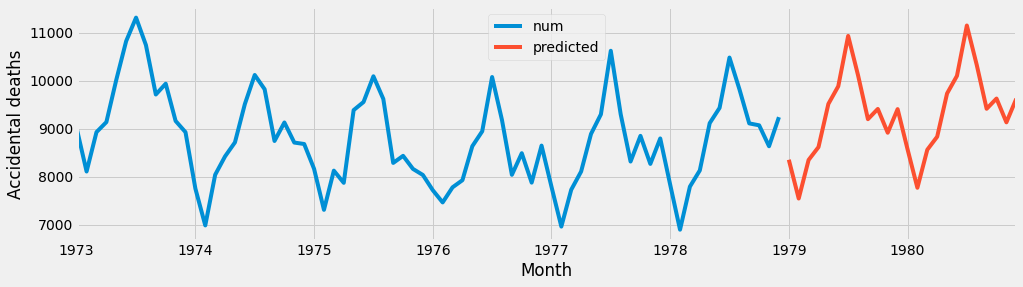

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
df_future.plot(ax=ax)
ax.set_ylabel('Accidental deaths')
plt.show()